In [24]:
import os

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

#import cPickle as pickle
import pickle

import matplotlib.pyplot as plt
%matplotlib inline


#Grow as needed
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras.models import load_model

# Load model
This model is quite bad, probably due the size limited, non-filtered and non-standardized prior dataset used during training (and my lack of patience during training)

In [2]:
name = "models/enum2enum_val_loss_0.1885" 

In [3]:
#model = load_model("%s_full.h5"%name)

In [ ]:
#For some versions of Keras it was necessary to Preload the module
#from keras.layers import CuDNNLSTM as LSTM

In [4]:
mol2lat_model = load_model("%s_mol2lat.h5"%name)
#lat2stat_model = load_model("%s_lat2stat.h5"%name)
#sample_model = load_model("%s_sample_model.h5"%name)

/home/kfxl284/miniconda3/envs/keras2/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
import h5py
import numpy as np
import ast

h5f = h5py.File('data/chembl_mols_as_binstrings.h5', 'r')

print(list(h5f.items()))

info = ast.literal_eval(h5f['info'].value.decode("utf-8"))

print(info.keys())

print(len(info['charset']))
print(info['maxlen'])

charset = info['charset']
maxlen = info['maxlen']

mols = h5f['mols'][0:95000]

[('info', <HDF5 dataset "info": shape (), type "|O">), ('mols', <HDF5 dataset "mols": shape (100000,), type "|S2119">)]
dict_keys(['propnames', 'maxlen', 'charset'])
45
190


In [7]:
mols_test = h5f['mols'][95000:]

In [8]:
from molvecgen import HetSmilesGenerator
from molvecgen import SmilesVectorizer

In [10]:
smilesvec1 = SmilesVectorizer(canonical=True, augment=False, maxlength=maxlen, charset=charset, binary=True)
#smilesvec2 = SmilesVectorizer(canonical=False, augment=True, maxlength=maxlen, charset=charset, binary=True, leftpad=False)

In [11]:
test_smi_i = smilesvec1.transform(mols_test)

In [12]:
latent_vectors = mol2lat_model.predict(test_smi_i)#, batch_size=24)

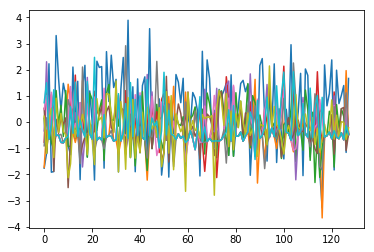

In [13]:
#Variation in the latent space of first 10 molecules
_ = plt.plot(latent_vectors[0:10].T)

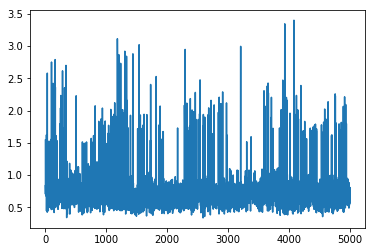

In [14]:
plt.plot(latent_vectors.std(axis=1))

In [15]:
lat2stat_model = load_model("%s_lat2stat.h5"%name)

In [16]:
states_init = lat2stat_model.predict(latent_vectors[0:1])

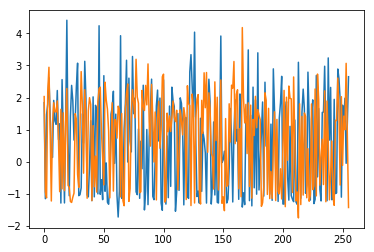

In [17]:
_ = plt.plot(states_init[0].T)
_ = plt.plot(states_init[1].T)
#_ = plt.plot(states_init[2].T)
#_ = plt.plot(states_init[3].T)

In [18]:
sample_model = load_model("%s_sample_model.h5"%name)

In [19]:
[l.name for l in sample_model.layers]

['input_8', 'LSTM1_decoder', 'BN_decoder', 'LSTM2_decoder', 'Dense_decoder']

In [20]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = lat2stat_model.predict(latent)
    sample_model.get_layer("LSTM1_decoder").reset_states(states=[states[0],states[1]])
    sample_model.get_layer("LSTM2_decoder").reset_states(states=[states[2],states[3]])
    #Prepare the input char
    startidx = smilesvec1._char_to_int[smilesvec1.startchar]
    samplevec = np.zeros((1,1,smilesvec1.dims[-1]))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(1000):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = smilesvec1._int_to_char[sampleidx]
        if samplechar != smilesvec1.endchar:
            smiles = smiles + smilesvec1._int_to_char[sampleidx]
            samplevec = np.zeros((1,1,smilesvec1.dims[-1]))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [51]:
i=9 #Select Molecule index
print(Chem.MolToSmiles(Chem.Mol(mols_test[i])))
reconstructed = latent_to_smiles(latent_vectors[i:i+1])
print(reconstructed)

N=C(N)c1cc(-c2nc(-c3ccccc3)cs2)c(C(F)(F)F)s1
c1cc(-c2sc(C(F)(F)F)nc2-c2ccccc2C(N)=N)sc1


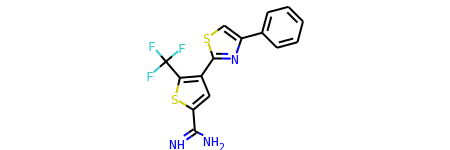

In [52]:
Chem.Mol(mols_test[i])

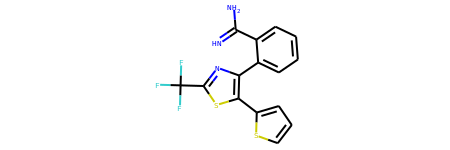

In [53]:
Chem.MolFromSmiles(reconstructed)

In [54]:
# How many well formed
x_latent = mol2lat_model.predict(test_smi_i[:1000])

wrong = 0
for i in range(100):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.2F percent wrongly formatted smiles"%(wrong/float(1000)*100))

RDKit ERROR: [10:12:41] SMILES Parse Error: unclosed ring for input: 'C1CCCN(CCCN2CCC(c3cc4c(cc3)OCO4)CC2)(=O)c1cc(OC)c(OC)cc1OC'
RDKit ERROR: [10:12:41] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [10:12:41] Can't kekulize mol.  Unkekulized atoms: 0 2 3 5 7
RDKit ERROR: 


C1CCCN(CCCN2CCC(c3cc4c(cc3)OCO4)CC2)(=O)c1cc(OC)c(OC)cc1OC
C(C)C[C@H](NC(=O)[C@H](CCCNc1ccc(C(F)(F)F)cc1)=O)C
c1(N)nc(N)c(C)c(C(=O)Nc2ccc(NCCSc3ccc([N+](=O)[O-])cc3)nc2)c1=O


RDKit ERROR: [10:12:41] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit ERROR: 


c1cccc(CNc2ccnc3ccccn23)c1


RDKit ERROR: [10:12:41] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:12:41] non-ring atom 2 marked aromatic


c1cc(N2CCN(CCCCN3C(=O)C(C)(C)CC3)=O)ccc2N1C(=O)c1ccc(Br)cc1.FC(F)(F)=O
O(c1ccc([C@@H]2CCN3C(=O)O[C@@H](CS3)F)c2)c1


RDKit ERROR: [10:12:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:12:41] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [10:12:42] SMILES Parse Error: unclosed ring for input: 'c12c(cc3c(c1)OCO3)n1c3c(ccc(OC)c3)nc1C(=O)C=C2[C@](C)(CO)C1'


c1cccc2c(N(CC)[C@@H](C)c3cccnc3)cnc12
c1cc(Br)ccc1[C@@H](Nc1cccnc1)c1nccc1
c12c(cc3c(c1)OCO3)n1c3c(ccc(OC)c3)nc1C(=O)C=C2[C@](C)(CO)C1


RDKit ERROR: [10:12:42] SMILES Parse Error: unclosed ring for input: 'c12c(cc3c(c1)OCOC(C)=O)c3c(c1)-n1c(c(C(OCC)=O)nc1C(OC(C)C)=O)CC2'
RDKit ERROR: [10:12:42] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 25
RDKit ERROR: 


c12c(cc3c(c1)OCOC(C)=O)c3c(c1)-n1c(c(C(OCC)=O)nc1C(OC(C)C)=O)CC2
c1c([C@@H]2[C@@H](CO)CCC(=O)O2)cc2c(cc(OCc3ccc4c(c3)[nH]c4)ccn2)OC1


RDKit ERROR: [10:12:42] Can't kekulize mol.  Unkekulized atoms: 0 2 19 20 31
RDKit ERROR: 


c1(N)c(CNc2cc(CN3CCOCC3)cc(O)c2)ccc(C(c2cc([N+](=O)[O-])nn2)c1)=O


RDKit ERROR: [10:12:42] Can't kekulize mol.  Unkekulized atoms: 14 16
RDKit ERROR: 
RDKit ERROR: [10:12:42] Can't kekulize mol.  Unkekulized atoms: 0 2 3 28 29
RDKit ERROR: 


c1(-c2cc(C)nc(NC(=O)C)c2)nc(-c2sc(C#N)s2)c1
c1(N)cc(C(=O)Nc2cc(C(C)C)c(NC(=O)Nc3ccc(C)cc3)[n+]([O-])c2)nc1C


RDKit ERROR: [10:12:43] SMILES Parse Error: unclosed ring for input: 'c1cc([C@@H]2[C@H](C(=O)OC)N(C)C(=O)[C@@H]2SC2)cc1[N+](=O)[O-]'


c1cc([C@@H]2[C@H](C(=O)OC)N(C)C(=O)[C@@H]2SC2)cc1[N+](=O)[O-]


RDKit ERROR: [10:12:43] Can't kekulize mol.  Unkekulized atoms: 0 1 13 14 15 16 31
RDKit ERROR: 
RDKit ERROR: [10:12:43] non-ring atom 26 marked aromatic


c1c(C(=O)OC[C@H]2[C@@H](O)CC[C@@H]2C)c2ccc(OCc3ccc4c(cccc4)n3)c(=O)c1C2
c1c([C@@H]2CC[C@@H](CN3CCOCC3)O2)cc2c(cc3c(cccc3)c2)c1[nH]c1c(O)c(O)n1


RDKit ERROR: [10:12:43] Explicit valence for atom # 21 C, 5, is greater than permitted


c1ccc2c3c(cccc3)-c3nc4c(cccc4)nc3c2[C@@]1(CCNCCN)=O.Cl


RDKit ERROR: [10:12:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20
RDKit ERROR: 
RDKit ERROR: [10:12:44] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6
RDKit ERROR: 


C1CN(CCCN2C(=O)c3ccccc3C(=O)C2)ccc1C(CN1CC)c1
c1c(OC)ccc([C@@H]2[C@@H](C)[C@@](C)(C(=O)OC)Oc3cc4c(cc3c(N(C)C)cc4)cc2)O1


RDKit ERROR: [10:12:44] Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24 25 26 29 30
RDKit ERROR: 
RDKit ERROR: [10:12:44] SMILES Parse Error: unclosed ring for input: 'c1(N)cc(C(=O)Nc2cc(C(C)(C)C)c(OC)cc2)cc(C2=NCCN(C)c2ccc([N+]([O-])=O)n12)C'


c1c([C@@H]2[C@@H](CO)CCN(C(=O)c3ccc4c(cc3)OCO4)c2)cc2c(cc(OC)cc2)[nH]1
c1(N)cc(C(=O)Nc2cc(C(C)(C)C)c(OC)cc2)cc(C2=NCCN(C)c2ccc([N+]([O-])=O)n12)C


RDKit ERROR: [10:12:44] SMILES Parse Error: unclosed ring for input: 'c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CCC2N1'


c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CCC2N1


RDKit ERROR: [10:12:44] SMILES Parse Error: unclosed ring for input: 'c1cc(-c2ccc(C(F)(F)F)cc2)nc(-c2ccs1)N=C/N'


c1cc(-c2ccc(C(F)(F)F)cc2)nc(-c2ccs1)N=C/N


RDKit ERROR: [10:12:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
RDKit ERROR: 
RDKit ERROR: [10:12:45] SMILES Parse Error: unclosed ring for input: 'C(=C/CCCC[C@@H]1[C@@H](O)[C@@H](/C=C/C(=O)O)C(C)(C)COc1ccc(-c2ccccc2)cc1)O'


c1cc(N2C(=O)O[C@@H]3C[C@H](C(=O)OC)CC3)cc2N(S(C)(=O)=O)[C@H]1
C(=C/CCCC[C@@H]1[C@@H](O)[C@@H](/C=C/C(=O)O)C(C)(C)COc1ccc(-c2ccccc2)cc1)O


RDKit ERROR: [10:12:45] SMILES Parse Error: unclosed ring for input: 'C1CCC2CC[C@]3(C)[C@@H](O)[C@@H](C)CCC3=CC(=O)C2C1C[C@@H](O)C1=O'
RDKit ERROR: [10:12:45] SMILES Parse Error: unclosed ring for input: 'c1cc(N2C(=O)O[C@@H](COC)C2)ccc1NS(=O)(=O)C1'


C1CCC2CC[C@]3(C)[C@@H](O)[C@@H](C)CCC3=CC(=O)C2C1C[C@@H](O)C1=O
c1cc(N2C(=O)O[C@@H](COC)C2)ccc1NS(=O)(=O)C1


RDKit ERROR: [10:12:46] Can't kekulize mol.  Unkekulized atoms: 27 28 33
RDKit ERROR: 
RDKit ERROR: [10:12:46] SMILES Parse Error: unclosed ring for input: 'c1cc(CCn2cnc3c2ccc(CC(=O)OCC)c3)SC(=O)N1CC1'
RDKit ERROR: [10:12:46] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 


c1cc(C(=O)N(CCCC)C(=O)O)ccc1C(c1cccc2c1OCC2)n1cc(CN(C)C)c1
c1cc(CCn2cnc3c2ccc(CC(=O)OCC)c3)SC(=O)N1CC1
c1cc(N(C)C)ccc1[S+]([O-])Cc1nccn1


RDKit ERROR: [10:12:46] SMILES Parse Error: unclosed ring for input: 'C1CC(C(=O)NC(C(=O)O)CCC(N[C@H](Cc2ccc(C#N)cc2)CC)=O)Cc1scn1'
RDKit ERROR: [10:12:46] SMILES Parse Error: unclosed ring for input: 'c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CN2CC1'
RDKit ERROR: [10:12:46] SMILES Parse Error: unclosed ring for input: 'c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CC2NCC1'


C1CC(C(=O)NC(C(=O)O)CCC(N[C@H](Cc2ccc(C#N)cc2)CC)=O)Cc1scn1
c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CN2CC1
c1cc(COC(=O)c2ccc(C#N)cc2)n2c(nc1)C(=O)CC2NCC1


RDKit ERROR: [10:12:46] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 15 18
RDKit ERROR: 
RDKit ERROR: [10:12:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 15 16 17 18 19 20
RDKit ERROR: 


c1cc(C)ccc1-c1cc2c(ccc(O)n2)n(C)c1
c1cc(NC(=O)Nc2ccc(OC)cc2)c2ccncc2CC1


RDKit ERROR: [10:12:46] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [10:12:46] SMILES Parse Error: unclosed ring for input: 'C(C)(C)C(=O)N1CCC(CN2CCN(C(=O)c3ccc(OC)cc3)CC2)[C@H]1CCC(=O)O[C@H]1'
RDKit ERROR: [10:12:47] SMILES Parse Error: unclosed ring for input: 'C1CC2CCC(CC(=O)N2CCN(C(=O)c3ccc(OC)cc3)[C@H]2C)C[C@@H]1C'


C(C)(C)C[C@H](NC(=O)[C@H](NC(=O)CCc1ccc(F)c(OC)c1)=O)C
C(C)(C)C(=O)N1CCC(CN2CCN(C(=O)c3ccc(OC)cc3)CC2)[C@H]1CCC(=O)O[C@H]1
C1CC2CCC(CC(=O)N2CCN(C(=O)c3ccc(OC)cc3)[C@H]2C)C[C@@H]1C


RDKit ERROR: [10:12:47] Explicit valence for atom # 15 O, 3, is greater than permitted
RDKit ERROR: [10:12:47] SMILES Parse Error: unclosed ring for input: 'C1CCCCC1NC(=O)[C@H]1NCCCc1cc(Cl)cc([N+](=O)[O-])c1'
RDKit ERROR: [10:12:47] SMILES Parse Error: unclosed ring for input: 'C1CC(C(=O)NC(C(=O)O)CCC(N[C@H](Cc2ccc(C#N)cc2)CC)=O)Cc1scn1'


C1C2CCC(C#Cc3ccnc(NC)n3)O2C1
C1CCCCC1NC(=O)[C@H]1NCCCc1cc(Cl)cc([N+](=O)[O-])c1
C1CC(C(=O)NC(C(=O)O)CCC(N[C@H](Cc2ccc(C#N)cc2)CC)=O)Cc1scn1


RDKit ERROR: [10:12:47] Can't kekulize mol.  Unkekulized atoms: 27 28 29
RDKit ERROR: 
RDKit ERROR: [10:12:47] Explicit valence for atom # 15 Br, 2, is greater than permitted


c1(C(=O)OCc2ccc(C)cc2)cc2c(nc1)NC(=O)C(SC)C2OCn1cnc1
C1C2CCC(N1C)CCc1cncnc1Br2


RDKit ERROR: [10:12:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [10:12:47] Explicit valence for atom # 13 C, 5, is greater than permitted


c1cc(Br)ccc1NC(=O)NC(C)Oc1ccc(F)cc1Cc1ccnc1
C(C(C)C)C(=O)NC(C1CCCC1)C(N[C@H](C(=O)O)Cc1ccc(S(=O)(N)=O)cc1)#N


RDKit ERROR: [10:12:47] Explicit valence for atom # 20 N, 4, is greater than permitted


C1CCCCC1OP(OCC)(OCCCCC)(N1CCN(C(Cl)Cl)=O)N1


RDKit ERROR: [10:12:48] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [10:12:48] SMILES Parse Error: unclosed ring for input: 'C1CCCN(CCCN2C(=O)[C@@H](c3ccc(OC)cc3)C3=O)S(=O)(c3cccc3)[C@H]12'
RDKit ERROR: [10:12:48] SMILES Parse Error: unclosed ring for input: 'C1CCCCC1NC(=O)[C@H]1NCCCc1cc(Cl)cc([N+](=O)[O-])c1'


c1cc(N2C(=O)N(CCOc3ccc(C#N)cc3)=N2)ccc1
C1CCCN(CCCN2C(=O)[C@@H](c3ccc(OC)cc3)C3=O)S(=O)(c3cccc3)[C@H]12
C1CCCCC1NC(=O)[C@H]1NCCCc1cc(Cl)cc([N+](=O)[O-])c1


RDKit ERROR: [10:12:48] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:12:48] SMILES Parse Error: unclosed ring for input: 'C(C(C)C)C(=O)NC(C1CCC(C(=O)N[C@H](C(O)=O)Cc2ccc(SC)cc2)n1)sc1'


C1CCCN(CCCOc2ccc(C(=O)N3C(=O)[C@@H](Cc4ccc(SC)cc4)C3)c2)=O1
C(C(C)C)C(=O)NC(C1CCC(C(=O)N[C@H](C(O)=O)Cc2ccc(SC)cc2)n1)sc1
c1c(C#N)ccc(OCCN2CCN(C(=O)[C@@H](CS)Cc3ccc(C(=O)O)cc3)=O)c12
5.30 percent wrongly formatted smiles


RDKit ERROR: [10:12:48] Explicit valence for atom # 13 N, 4, is greater than permitted


RDKit ERROR: [10:13:12] SMILES Parse Error: unclosed ring for input: 'C1CCCN(CCCN2CCC(c3cc4c(cc3)OCO4)CC2)(=O)c1cc(OC)c(OC)cc1OC'
RDKit ERROR: [10:13:12] SMILES Parse Error: unclosed ring for input: 'C1CC(CN(CCOc2cc3c(cc2)OCO3)CC2)cc1c(C(NCC2CCOC2)=O)cc(O)c1'


C1CCCN(CCCN2CCC(c3cc4c(cc3)OCO4)CC2)(=O)c1cc(OC)c(OC)cc1OC
C1CC(CN(CCOc2cc3c(cc2)OCO3)CC2)cc1c(C(NCC2CCOC2)=O)cc(O)c1


RDKit ERROR: [10:13:12] SMILES Parse Error: unclosed ring for input: 'C1CN(CCC(Oc2cc3c(cc2)OCO3)CCN(C)CC2)cc(OC)c2c1sc(C(=O)C)c2'
RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 30
RDKit ERROR: 


C1CN(CCC(Oc2cc3c(cc2)OCO3)CCN(C)CC2)cc(OC)c2c1sc(C(=O)C)c2
C1CN(CCC(Oc2cc3c(cc2)OCO3)CCN(C)C)Cc2cc(OC)cc(=O)s21


RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 17 18 20
RDKit ERROR: 


C1CN(CC(=O)OCC)CC1c1ccc(OC)c2c1sc(CN(C)c1ccc(O)c1)C2


RDKit ERROR: [10:13:13] SMILES Parse Error: unclosed ring for input: 'c1c(OC)ccc(-c2cc(C(=O)N3CCN(CCOC)C3)cc(C#N)c2)c1n1'
RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6
RDKit ERROR: 
RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 8 9 20 21 23
RDKit ERROR: 


c1c(OC)ccc(-c2cc(C(=O)N3CCN(CCOC)C3)cc(C#N)c2)c1n1
c1c(OC)ccc(-c2cc(C(=O)N3CCN(CC)CC3)ccc2OC)s1
c1c(OC)ccc(-c2cc(C(=O)NC3CCN(C)CC3)cc2sc1)OC


RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21
RDKit ERROR: 
RDKit ERROR: [10:13:13] SMILES Parse Error: unclosed ring for input: 'c1c(OC)ccc(-c2ccc(C(=O)NC3CCN(C)C3)cc2)c1sc1O'
RDKit ERROR: [10:13:13] SMILES Parse Error: unclosed ring for input: 'c1c(OC)ccc(-c2ccc(C(=O)NC3CCN(C)C3)cc2)c1sc1'


c1c(OC)ccc(-c2cc(C(=O)NC3CCN(C)CC3)cc2)c(O)s1
c1c(OC)ccc(-c2ccc(C(=O)NC3CCN(C)C3)cc2)c1sc1O
c1c(OC)ccc(-c2ccc(C(=O)NC3CCN(C)C3)cc2)c1sc1


RDKit ERROR: [10:13:13] Can't kekulize mol.  Unkekulized atoms: 0 1 11 22 23
RDKit ERROR: 


c1c(-c2ccc(OC)cc2)sc(C(=O)NCCN2CC(C)O2)cc1


RDKit ERROR: [10:13:14] SMILES Parse Error: unclosed ring for input: 'c1c(-c2ccc(OC)cc2)nc(C(=O)NC/C(=N)N)c2ccs1'
RDKit ERROR: [10:13:14] Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 17
RDKit ERROR: 


c1c(-c2ccc(OC)cc2)nc(C(=O)NC/C(=N)N)c2ccs1
c1c(-c2ccc(OC)cc2)nc(-c2ccsc2)s1C(=O)NC


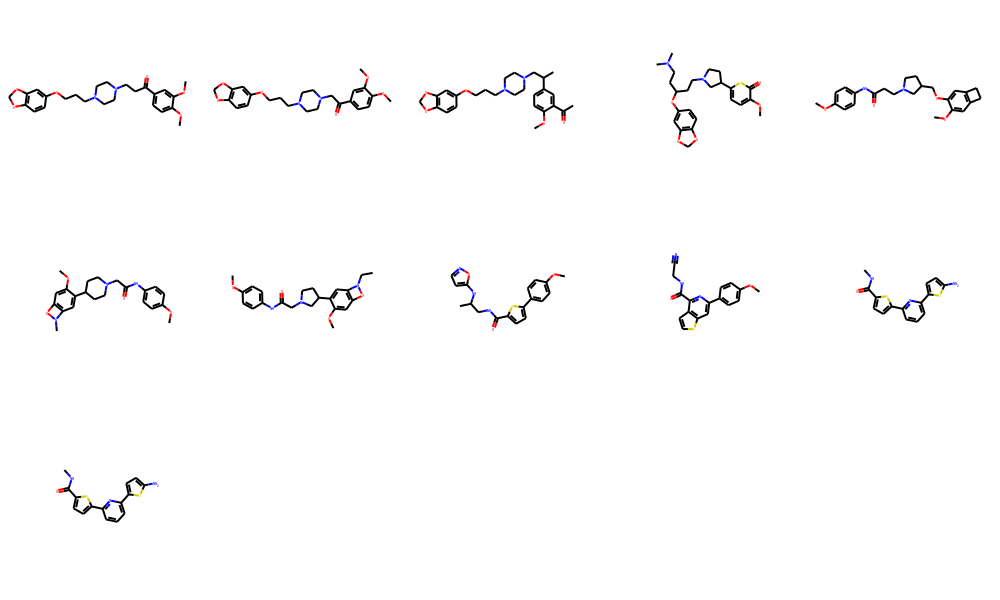

In [56]:
#Interpolation

#Interpolation test in latent_space
i = 1
j= 10
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)
         
Draw.MolsToGridImage(mols1, molsPerRow=5)


RDKit ERROR: [10:13:33] SMILES Parse Error: unclosed ring for input: 'O(C(N1CCN(c2c(F)c(F)c(C)c3c(n2)c(C(O)=O)c(=O)c(C)n3)c1)CC1)NC'
RDKit ERROR: [10:13:33] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 19
RDKit ERROR: 


O(C(N1CCN(c2c(F)c(F)c(C)c3c(n2)c(C(O)=O)c(=O)c(C)n3)c1)CC1)NC
C1(C)CN(CCOCCn2c(=O)c3c(c(=O)c2)c(F)c(SC)n3C1)N


RDKit ERROR: [10:13:33] SMILES Parse Error: unclosed ring for input: 'Fc1c(F)cc2c(c1)C(C(=O)O)C(Nc1c(O)c(C(N)C)cn1)CC1'
RDKit ERROR: [10:13:33] Can't kekulize mol.  Unkekulized atoms: 11 15 17 19 20 22 24
RDKit ERROR: 
RDKit ERROR: [10:13:33] SMILES Parse Error: extra close parentheses for input: 'C1C(=O)N(c2c(F)c(F)c(F)cc2)C(=O)c2c1CC(C1OCC1)NC2)nc1'


Fc1c(F)cc2c(c1)C(C(=O)O)C(Nc1c(O)c(C(N)C)cn1)CC1
C1N(CC2CC2)CCn2c(=O)c(C(=O)O)c(O)c(C)c2c(F)c(F)c1F.C#N
C1C(=O)N(c2c(F)c(F)c(F)cc2)C(=O)c2c1CC(C1OCC1)NC2)nc1


RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'C1(=O)C(C)C(=O)N(CC2CC2)C(=O)c2c(F)c(F)c(OC)c(OC)c2[nH]c12.C1(C)O'
RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'C(C)OC(=O)c1c(N2CCC2)c2c(c(N3CCOCC3)cnc2n1)(=O)c1c(F)c(F)F'
RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'c1(N2CCN(C(=O)C)CC2)c(F)c2c(c(=O)c(C(O)=O)cn2CC)c1NC1'


C1(=O)C(C)C(=O)N(CC2CC2)C(=O)c2c(F)c(F)c(OC)c(OC)c2[nH]c12.C1(C)O
C(C)OC(=O)c1c(N2CCC2)c2c(c(N3CCOCC3)cnc2n1)(=O)c1c(F)c(F)F
c1(N2CCN(C(=O)C)CC2)c(F)c2c(c(=O)c(C(O)=O)cn2CC)c1NC1


RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'C1(N(CC(=O)O)CCN(C)CC2)c2c(cc(F)c(F)c2)n2c(=O)c(C(=O)O)c1[C@H]2N'
RDKit ERROR: [10:13:34] Can't kekulize mol.  Unkekulized atoms: 0 6 10 14 15 16 20 22 23
RDKit ERROR: 


C1(N(CC(=O)O)CCN(C)CC2)c2c(cc(F)c(F)c2)n2c(=O)c(C(=O)O)c1[C@H]2N
c1(N2CCCC2)c(C(=O)O)cn(CC)c2cc(C(=O)N)c(F)cc12


RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'C1(=O)C(C(F)(F)F)CCN(C(=O)c2cc3c(cc2)[nH]c(=O)c1)CN1CCOC1'
RDKit ERROR: [10:13:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 12 13 25
RDKit ERROR: 


C1(=O)C(C(F)(F)F)CCN(C(=O)c2cc3c(cc2)[nH]c(=O)c1)CN1CCOC1
Fc1cc2c(N3CCN(C)CC3)c3c(n(C4C(O)C(O)C(O)C4)c(=O)c3c1=O)CC(O)N2


RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'COc1cc(=O)c2c(cc(F)c(N3CCC(C)CC3)c2)n1CCCC1.OC(=O)N(C)S(=O)(O)C'
RDKit ERROR: [10:13:34] SMILES Parse Error: unclosed ring for input: 'C(O)(C(=O)N1CCN(c2c(F)c(F)c(N3CC3CC3)c(C)c2C)c2n(C)c(=O)c1O)C2'


COc1cc(=O)c2c(cc(F)c(N3CCC(C)CC3)c2)n1CCCC1.OC(=O)N(C)S(=O)(O)C
C(O)(C(=O)N1CCN(c2c(F)c(F)c(N3CC3CC3)c(C)c2C)c2n(C)c(=O)c1O)C2
Oc1c2c(c(=O)c(C(=O)NCCN3CCC3)c(F)c2F)C(C)(C)O1


RDKit ERROR: [10:13:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 16 18
RDKit ERROR: 


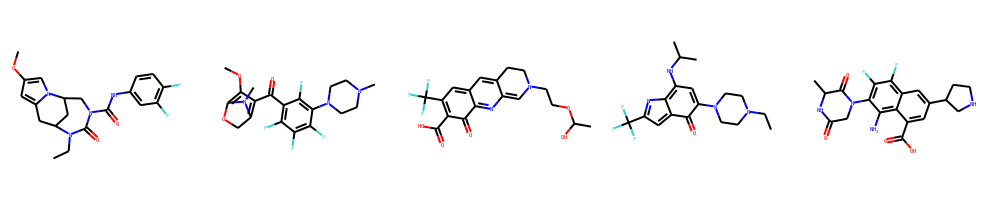

In [57]:
#Sample around the latent wector
i = 500
latent = x_latent[i:i+1]
scale = 0.7
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with 
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)

In [58]:
#Sampling with a temperature rescaling of the probability output before multinomial sampling

def latent_to_smiles(latent, temp=0.0):
    #decode states and set Reset the LSTM cells with them
    states = lat2stat_model.predict(latent)
    sample_model.get_layer("LSTM1_decoder").reset_states(states=[states[0],states[1]])
    sample_model.get_layer("LSTM2_decoder").reset_states(states=[states[2],states[3]])
    #Prepare the input char
    startidx = smilesvec1._char_to_int[smilesvec1.startchar]
    samplevec = np.zeros((1,1,smilesvec1.dims[-1]))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(100):
        o = sample_model.predict(samplevec)
        #Rescale o according to temperature
        if temp > 0:
            nextCharProbs = np.log(o) / temp
            nextCharProbs = np.exp(nextCharProbs)
            nextCharProbs = nextCharProbs / nextCharProbs.sum() - 1e-8 # Re-normalize for float64 to make exactly 1.0. 
            #print nextCharProbs.sum()
            sampleidx = np.random.multinomial(1, nextCharProbs.squeeze(), 1).argmax()
        else:
            sampleidx = np.argmax(o)
        samplechar = smilesvec1._int_to_char[sampleidx]
        if samplechar != smilesvec1.endchar:
            smiles = smiles + smilesvec1._int_to_char[sampleidx]
            samplevec = np.zeros((1,1,smilesvec1.dims[-1]))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

RDKit ERROR: [10:23:07] Explicit valence for atom # 22 O, 3, is greater than permitted
RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C(CCl)CO[C@@]12O[C@@](C)(C(OC(=O)OC)O1)[C@@H](OC(C)(C)C)CN12'
RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@H]([C@H](C)O1)OC(C)(C)OCCC1N2'


Malformed: O1C(C)(C)O[C@@]2(COC(=O)N3[C@@H]([C@@H](C)OCCC)C3OCC2)O1CO
Malformed: C(CCl)CO[C@@]12O[C@@](C)(C(OC(=O)OC)O1)[C@@H](OC(C)(C)C)CN12
Malformed: C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@H]([C@H](C)O1)OC(C)(C)OCCC1N2


RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C1(C)O[C@]2(COC(=O)OC)[C@@H](OC(C)C)O[C@@]2(COC(Cl)CCN2)[C@@H]1O'
RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'O1C(C)(C)CC[C@@]2(OC)[C@@H](OC(=O)OC(C)C)O[C@@H]3N(CCO)C(O1)C2'
RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@](C)(CCN1CC[C@@H](OC)O1)O2'


Malformed: C1(C)O[C@]2(COC(=O)OC)[C@@H](OC(C)C)O[C@@]2(COC(Cl)CCN2)[C@@H]1O
Malformed: O1C(C)(C)CC[C@@]2(OC)[C@@H](OC(=O)OC(C)C)O[C@@H]3N(CCO)C(O1)C2
Malformed: C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@](C)(CCN1CC[C@@H](OC)O1)O2


RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OC([C@@]12O[C@@H](COC(C)=O)[C@@]1(OC)C(OC(Cl)C1)OCO2)N'
RDKit ERROR: [10:23:07] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OO[C@@]12O[C@@](C)(CC[C@@H]1OC(=O)OCC)[C@@H](N1CCOC(C)(C)F)O2'
RDKit ERROR: [10:23:08] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OC(=O)OC[C@]1(OCC)[C@@H]2OC(C)(C)O[C@@H]1CN2CC1OC'


Malformed: C(C)(C)OC([C@@]12O[C@@H](COC(C)=O)[C@@]1(OC)C(OC(Cl)C1)OCO2)N
Malformed: C(C)(C)OO[C@@]12O[C@@](C)(CC[C@@H]1OC(=O)OCC)[C@@H](N1CCOC(C)(C)F)O2
Malformed: C(C)(C)OC(=O)OC[C@]1(OCC)[C@@H]2OC(C)(C)O[C@@H]1CN2CC1OC


RDKit ERROR: [10:23:08] SMILES Parse Error: unclosed ring for input: 'C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@](C)(CC[C@@H]1OC(=O)N1CCO2)[C@@H](F)C'
RDKit ERROR: [10:23:08] SMILES Parse Error: unclosed ring for input: 'C(C)(C)O[C@@]12O[C@H](COC(=O)OC)[C@@]1(OC)C(COC(C)C)N1C[C@@H]2O'


Malformed: C(C)(C)OC(OC(C)=O)O[C@@]12O[C@@](C)(CC[C@@H]1OC(=O)N1CCO2)[C@@H](F)C
Malformed: C(C)(C)O[C@@]12O[C@H](COC(=O)OC)[C@@]1(OC)C(COC(C)C)N1C[C@@H]2O
Malformed: C(C)(C)O[C@@]1(OCCOC(C)(C)C)OC(=O)N2[C@@H]3[C@@](COC(=O)O)[C@@H]3C1


RDKit ERROR: [10:23:08] SMILES Parse Error: unclosed ring for input: 'C(C)(C)O[C@@]1(OCCOC(C)(C)C)OC(=O)N2[C@@H]3[C@@](COC(=O)O)[C@@H]3C1'


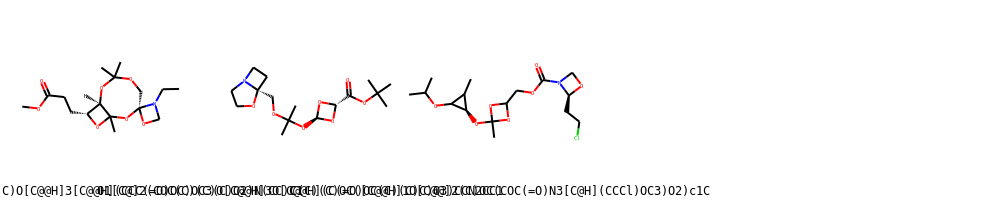

In [81]:
# Sample with temperature scaling
t = 0.2
i = 0
lat = x_latent[i:i+1]

mols = []
labels = []

for i in range(15):
    smiles = latent_to_smiles(lat, temp=t)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
        labels.append(smiles)
    else:
        print("Malformed: %s"%smiles)
        
        
Draw.MolsToGridImage(mols, molsPerRow=5, legends=labels)

In [82]:
#Testing fraction malformed with temperature sampling

mols = []
labels = []

mol_i = 1
test_mol = mols_test[mol_i]
lat = x_latent[mol_i:mol_i+1]
malformed = 0

t = 0.2

for i in range(100):
    smiles = latent_to_smiles(lat, temp=t)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
        labels.append(smiles)
    else:
        malformed = malformed +1
        #print "Malformed: %s"%smiles

print(malformed)

RDKit ERROR: [10:24:14] SMILES Parse Error: unclosed ring for input: 'C1CC(CN(CCOc2ccc3c(c2)OCO3)CC2)cc1c(c2c(OC)cc(OC)c2)CCNCC1'
RDKit ERROR: [10:24:14] Can't kekulize mol.  Unkekulized atoms: 17 18 19 22 34
RDKit ERROR: 
RDKit ERROR: [10:24:14] SMILES Parse Error: unclosed ring for input: 'c1c(OC)cc2c(c1)CCN(CCCN1CCC(c3cc(OC)c(OC)cc3)(=O)C1)CCCO1CO2'
RDKit ERROR: [10:24:14] Can't kekulize mol.  Unkekulized atoms: 24 25 26 29 32
RDKit ERROR: 
RDKit ERROR: [10:24:14] SMILES Parse Error: unclosed ring for input: 'C1CN(CCCCN2CCC(c3cc4c(cc3)OCO4)CC2)cc(OC)c(OC)c1C(=O)OC1'
RDKit ERROR: [10:24:14] Explicit valence for atom # 15 N, 4, is greater than permitted
RDKit ERROR: [10:24:15] SMILES Parse Error: unclosed ring for input: 'C1CCCN(CCCN2CCC(c3cc4c(cc3)OCO4)CC2)(=O)c1cc(OC)c(OC)c(OC)c1'
RDKit ERROR: [10:24:15] SMILES Parse Error: unclosed ring for input: 'C1CC(CN(CCOc2ccc3c(c2)OCO3)CC2)cc1c(OC)cc2c1NC(CCCOC)=O'
RDKit ERROR: [10:24:15] SMILES Parse Error: unclosed ring for input: 'C1(COc2c

70


RDKit ERROR: [10:24:23] Explicit valence for atom # 10 C, 5, is greater than permitted
